In [983]:
'''
Data Scraping: You're already scraping data from a website. You might need to modify the URL or the scraping logic to get data for individual players instead of teams. You can use libraries like BeautifulSoup or Scrapy for more complex scraping tasks.

Data Cleaning: After scraping the data, you'll likely need to clean it up. This might involve handling missing values, converting data types, or renaming columns. Pandas is a great library for this.

Data Analysis: To create projections, you'll need to perform some sort of analysis on the historical data. This could be as simple as calculating average points per game, or as complex as building a machine learning model. Libraries like numpy, pandas, and scikit-learn can help with this.

Data Visualization: You can use matplotlib or seaborn to create visualizations in Jupyter. You might create line graphs of a player's performance over time, bar graphs comparing different players, or heatmaps of player performance by game.

Output to Google Sheets: You can use the gspread library to interact with Google Sheets. You'll need to authenticate with your Google account, which can be done using the oauth2client library.
'''
# Import necessary libraries
import os
import time
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from scipy.stats import zscore

# Constants
COLUMN_ORDER = ['Player', 'Team', 'Position', 'GP', 'D Points', 'Goals', 'Total Assists', 'Shots', 'Special Teams Points', 'Hits', 'Shots Blocked', 'Takeaways', 'Faceoffs Won', 'TOI']
NUM_PLAYERS = 300
URL_ALL_STRENGTHS, URL_EVEN_STRENGTH = "https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=S&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", "https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=ev&score=all&stdoi=std&rate=n&team=ALL&pos=S&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"

In [984]:
# Scrape data
def scrape_data():
    all_strengths = URL_ALL_STRENGTHS
    even_strength = URL_EVEN_STRENGTH

    # Scrape the data
    all_strengths_df, even_strength_df = pd.read_html(all_strengths, index_col=0)[0], pd.read_html(even_strength, index_col=0)[0]

    # Save to csv
    all_strengths_df.to_csv('all_strengths.csv')
    even_strength_df.to_csv('even_strength.csv')

    return all_strengths_df, even_strength_df

In [985]:
def load_data():
    if os.path.exists('all_strengths.csv') and os.path.exists('even_strength.csv'):
        # Get the modification time of the CSVs
        all_strengths_modtime = os.path.getmtime('all_strengths.csv')
        even_strength_modtime = os.path.getmtime('even_strength.csv')

        # Get the current time
        current_time = time.time()

        if current_time - max(all_strengths_modtime, even_strength_modtime) < 3600:
            all_strengths_df = pd.read_csv('all_strengths.csv', index_col=0)
            even_strength_df = pd.read_csv('even_strength.csv', index_col=0)
        else:
            all_strengths_df, even_strength_df = scrape_data()
    else:
        all_strengths_df, even_strength_df = scrape_data()

    return all_strengths_df, even_strength_df

In [986]:
# Clean data
def clean_data(all_strengths, even_strength):
    all_strengths['D Points'] = np.where(all_strengths['Position'] == 'D', all_strengths['Total Points'], 0)
    all_strengths['Special Teams Points'] = all_strengths['Total Points'] - even_strength['Total Points']
    return all_strengths

In [987]:
# Analyze data
def analyze_data(clean_data, stat):
    df = clean_data.copy()
    df.index = df.index + 1 # Start index at 1
    categories = ['D Points', 'Goals', 'Total Assists', 'Shots', 'Special Teams Points', 'Hits', 'Shots Blocked', 'Takeaways', 'Faceoffs Won', 'TOI']

    # Calculate z-scores for overall season statistics
    for category in categories:
        df[category] = pd.to_numeric(df[category], errors='coerce')
    filtered_data = df[categories].apply(zscore)
    df['Season Value'] = filtered_data.sum(axis=1)
    season_rankings = df.sort_values('Season Value', ascending=False)

    # Normalize stats by games played
    for category in categories:
        df[category] = df[category] / df['GP']

    # Calculate z-scores for per game statistics
    filtered_data = df[categories].apply(zscore)
    df['Per Game Value'] = filtered_data.sum(axis=1)
    per_game_rankings = df.sort_values('Per Game Value', ascending=False)

    # Select and order columns
    season_rankings = season_rankings.loc[:, ['Season Value'] + COLUMN_ORDER]
    per_game_rankings = per_game_rankings.loc[:, ['Per Game Value'] + COLUMN_ORDER]

    # Add 'Rank' Column
    season_rankings.insert(0, 'Rank', range(1, len(season_rankings) + 1))
    per_game_rankings.insert(0, 'Rank', range(1, len(season_rankings) + 1))

    return season_rankings, per_game_rankings, stat

In [988]:
def find_value(season_rankings, per_game_rankings):
    # Ensure Player is set as index for both dataframes
    season_rankings.set_index('Player', inplace=True)
    per_game_rankings.set_index('Player', inplace=True)

    # Calculate discrepancy in value
    discrepancy = per_game_rankings['Per Game Value'] - season_rankings['Season Value']

    # Create a new DataFrame for discrepancy
    discrepancy_df = discrepancy.to_frame(name='Discrepancy')

    # Filter players where Per Game Value is higher than Season Value
    filtered_discrepancy = discrepancy_df[discrepancy_df['Discrepancy'] > 0]

    # sort player by discrepancy
    sorted_discrepancy = filtered_discrepancy.sort_values('Discrepancy', ascending=False)

    # Select top 50 players
    top_50_players = sorted_discrepancy.head(50)

    return top_50_players

In [989]:
def format_and_print(df):
    def color_rows(s):
        return ['background-color: #44475a' if i % 2 else 'background-color: #282a36' for i in range(len(s))]
    return df.style.apply(color_rows).hide(axis="index")

In [990]:
# Visualize rankings
def visualize_top_50_discrepancy(season_rankings, per_game_rankings):
    # Get top 50 players by discrepancy
    top_50_players = find_value(season_rankings, per_game_rankings)
    # Sort players by discrepancy in ascending order
    top_50_players = top_50_players.sort_values(by='Discrepancy', ascending=True)

    # Create horizontal bar plot
    plt.figure(figsize=(10, 10))
    bars = plt.barh(top_50_players.index, top_50_players['Discrepancy'])

    # Add discrepancy values at the end of each bar
    for bar in bars:
        xval = bar.get_width()
        plt.text(xval, bar.get_y() + bar.get_height()/2, round(xval, 2), va='center')

    plt.title('Top 50 Players by Discrepancy')
    plt.xlabel('Discrepancy')
    plt.ylabel('Player')
    plt.show()


In [991]:
# Output to Google Sheets
def output_to_gsheets(analyzed_data):
    # TODO: Implement this function
    pass

Season Rankings 2023-24


Rank,Season Value,Player,Team,Position,GP,D Points,Goals,Total Assists,Shots,Special Teams Points,Hits,Shots Blocked,Takeaways,Faceoffs Won,TOI
1,22.496430,Nathan MacKinnon,COL,C,43,0,23,46,195,29,29,38,22,336,990.216667
2,21.798865,Cale Makar,COL,D,38,48,9,39,114,25,18,69,37,0,943.133333
3,20.367040,Nikita Kucherov,T.B,R,43,0,28,44,187,33,18,16,37,2,939.883333
4,20.158426,J.T. Miller,VAN,C,43,0,19,39,92,24,91,32,22,450,848.433333
5,19.632877,Auston Matthews,TOR,C,40,0,33,15,175,15,38,52,38,351,848.516667
6,18.681217,Noah Dobson,NYI,D,42,43,6,37,94,18,31,97,19,0,1085.100000
7,18.255463,Quinn Hughes,VAN,D,43,51,11,40,103,17,16,33,24,0,1049.066667
8,18.041156,Rasmus Dahlin,BUF,D,42,34,12,22,123,11,87,82,24,0,1046.016667
9,17.324242,David Pastrnak,BOS,R,42,0,25,34,212,27,31,9,31,3,842.050000
10,17.226382,Evan Bouchard,EDM,D,39,40,10,30,115,20,28,57,25,0,890.050000


Per Game Rankings 2023-24


Rank,Per Game Value,Player,Team,Position,GP,D Points,Goals,Total Assists,Shots,Special Teams Points,Hits,Shots Blocked,Takeaways,Faceoffs Won,TOI
1,21.787535,Cale Makar,COL,D,38,1.263158,0.236842,1.026316,3.000000,0.657895,0.473684,1.815789,0.973684,0.000000,24.819298
2,19.088239,Nathan MacKinnon,COL,C,43,0.000000,0.534884,1.069767,4.534884,0.674419,0.674419,0.883721,0.511628,7.813953,23.028295
3,18.161772,Auston Matthews,TOR,C,40,0.000000,0.825000,0.375000,4.375000,0.375000,0.950000,1.300000,0.950000,8.775000,21.212917
4,17.910469,Connor McDavid,EDM,C,37,0.000000,0.432432,1.108108,3.108108,0.594595,1.324324,0.432432,1.054054,6.135135,21.537838
5,17.113403,Nikita Kucherov,T.B,R,43,0.000000,0.651163,1.023256,4.348837,0.767442,0.418605,0.372093,0.860465,0.046512,21.857752
6,16.413188,Jack Hughes,N.J,C,32,0.000000,0.468750,0.937500,4.312500,0.656250,0.218750,0.437500,1.062500,3.687500,20.509896
7,16.140059,Evan Bouchard,EDM,D,39,1.025641,0.256410,0.769231,2.948718,0.512821,0.717949,1.461538,0.641026,0.000000,22.821795
8,16.123332,J.T. Miller,VAN,C,43,0.000000,0.441860,0.906977,2.139535,0.558140,2.116279,0.744186,0.511628,10.465116,19.731008
9,15.636100,Noah Dobson,NYI,D,42,1.023810,0.142857,0.880952,2.238095,0.428571,0.738095,2.309524,0.452381,0.000000,25.835714
10,15.513973,Leon Draisaitl,EDM,C,39,0.000000,0.512821,0.641026,2.948718,0.461538,0.410256,0.307692,1.102564,11.000000,21.087179


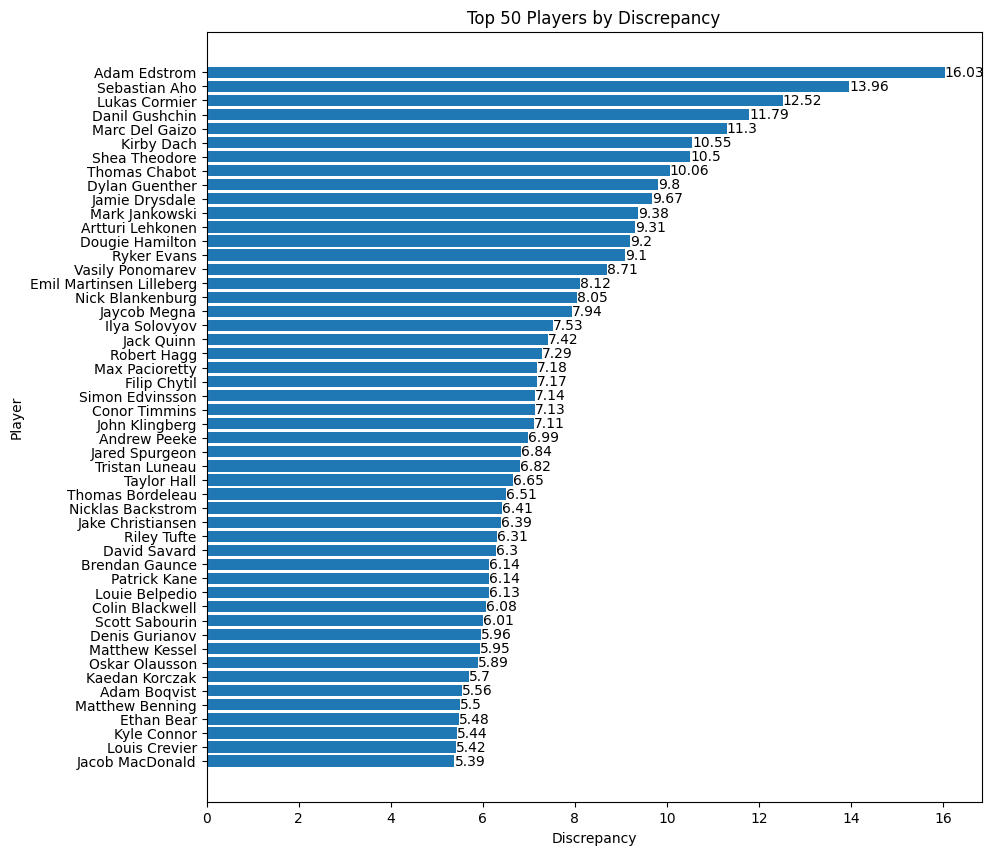

In [992]:
# Main function
def main():
    all_strengths, even_strength = load_data()
    cleaned_data = clean_data(all_strengths, even_strength)
    season_rankings, per_game_rankings, stat = analyze_data(cleaned_data, 'Special Teams Points')
    # Print player rankings
    with pd.option_context('display.max_rows', 10, 'display.max_columns', None):
        print('Season Rankings 2023-24')
        display(format_and_print(season_rankings.head(NUM_PLAYERS)))
        print('Per Game Rankings 2023-24')
        display(format_and_print(per_game_rankings.head(NUM_PLAYERS)))
    visualize_top_50_discrepancy(season_rankings, per_game_rankings)
    # output_to_gsheets(analyzed_data)

# Run the main function
if __name__ == "__main__":
    main()